# بسم الله

### So this is my first project using Pytorch (I barely used it lol) and my first experience with HuggingFace.  
### It's quite simple as you would expect from a first-time thing.  
### Anyhow, I'd love to hear your feedback and thank you in advance.

# Some Exploration & Processing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use("fivethirtyeight")

In [4]:
data = pd.read_csv("train.csv")

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data.shape

(7613, 5)

In [7]:
100 * data.isna().sum() / data.shape[0]

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [8]:
data.keyword[55:232]

55          ablaze
56          ablaze
57          ablaze
58          ablaze
59          ablaze
          ...     
227    annihilated
228    annihilated
229    annihilated
230    annihilated
231    annihilated
Name: keyword, Length: 177, dtype: object

In [9]:
data["keyword"].fillna("oov", inplace=True)
data["location"].fillna("unknown", inplace=True)

In [10]:
data.head()

,id,keyword,location,text,target
0,1,oov,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,oov,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,oov,unknown,All residents asked to 'shelter in place' are ...,1
3,6,oov,unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,oov,unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
data.drop("id", axis=1, inplace=True)

In [12]:
x, y = data.drop("target", axis=1), data["target"]

In [13]:
def transform_to_one_column(r):
    return r['keyword'] + ' ' + r["location"] + ' ' + r["text"]

In [14]:
x = x.apply(transform_to_one_column, axis="columns")

In [15]:
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string
punct = string.punctuation

In [16]:
def process(s):
    for p in punct:
        s = s.replace(p, '')
    s = s.lower()
    s = word_tokenize(s)
    s = " ".join(s)
    s = lemmatizer.lemmatize(s)
    return s

In [17]:
x = x.map(process)

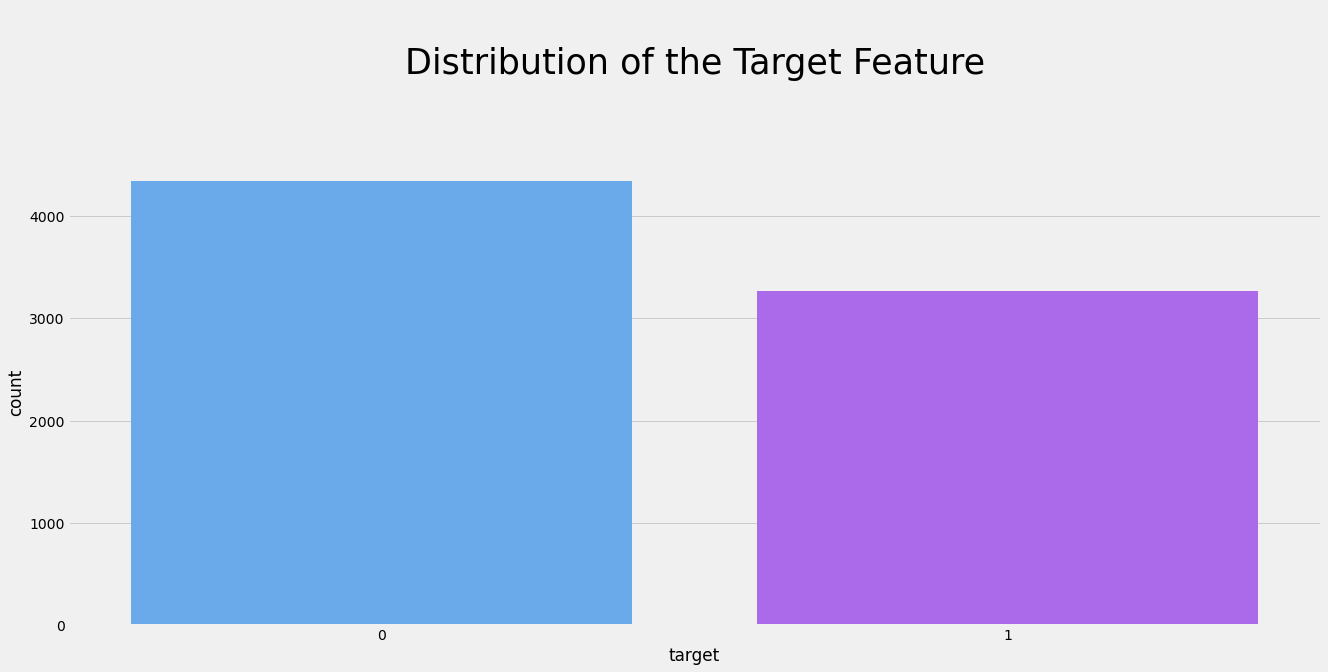

In [18]:
plt.figure(figsize=(20,8))
sns.countplot(x=y, palette="cool")
plt.title("\nDistribution of the Target Feature\n\n", fontsize=35)
plt.show()

In [19]:
def wordcount(r):
    return len(r.split())

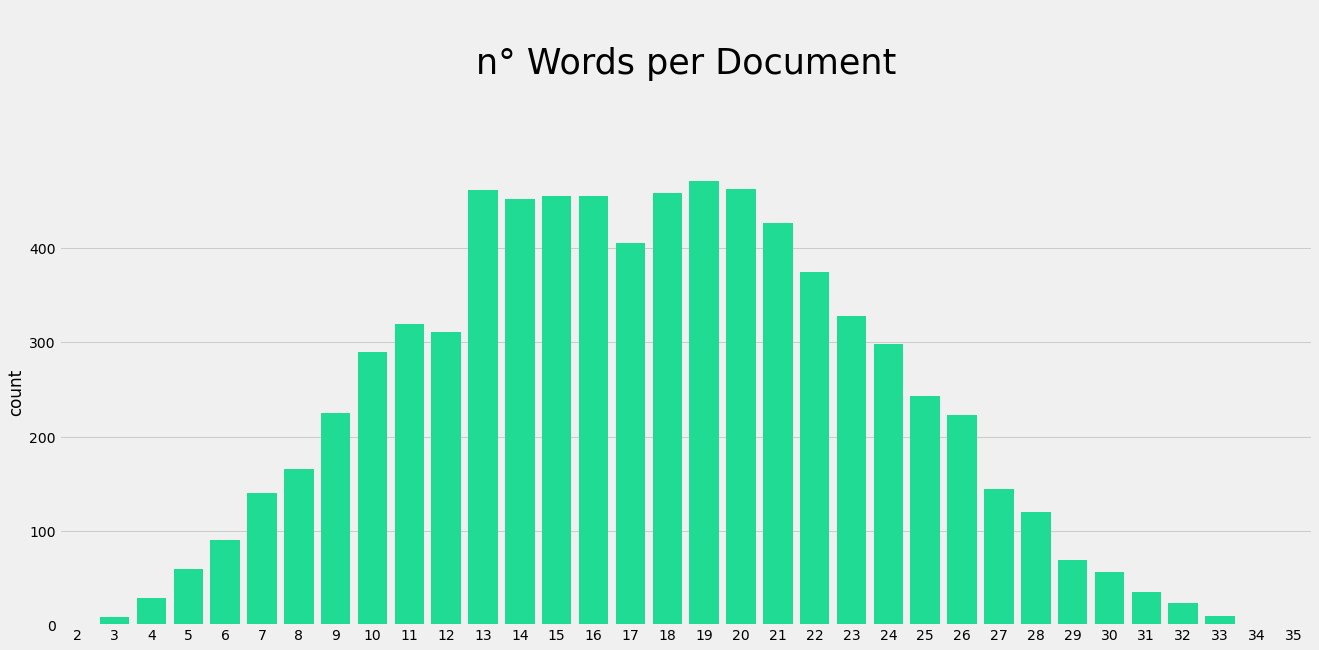

In [20]:
plt.figure(figsize=(20,8))
sns.countplot(x=x.apply(wordcount), color="mediumspringgreen")
plt.title("\nn° Words per Document\n\n", fontsize=35)
plt.show()

In [21]:
mydata = pd.concat([x,y], axis=1).rename({0:"text"}, axis=1)

In [22]:
mydata.to_csv("mydata.csv", index=False)

# Processing with HuggingFace

In [23]:
!pip install datasets

In [24]:
from datasets import load_dataset, Dataset

In [25]:
mydata

,text,target
0,oov unknown our deeds are the reason of this e...,1
1,oov unknown forest fire near la ronge sask canada,1
2,oov unknown all residents asked to shelter in ...,1
3,oov unknown 13000 people receive wildfires eva...,1
4,oov unknown just got sent this photo from ruby...,1
...,...,...
7608,oov unknown two giant cranes holding a bridge ...,1
7609,oov unknown ariaahrary thetawniest the out of ...,1
7610,oov unknown m194 0104 utc5km s of volcano hawa...,1
7611,oov unknown police investigating after an ebik...,1


In [26]:
mydata = load_dataset("csv", data_files="./mydata.csv")["train"]

Using custom data configuration default-57f0968f34a0bde8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\henri_m9qs9bn\.cache\huggingface\datasets\csv\default-57f0968f34a0bde8\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
mydata

Dataset({
    features: ['text', 'target'],
    num_rows: 7613
})

In [28]:
mydata = mydata.train_test_split(test_size=0.1)

In [29]:
mydata

DatasetDict({
    train: Dataset({
        features: ['text', 'target'],
        num_rows: 6851
    })
    test: Dataset({
        features: ['text', 'target'],
        num_rows: 762
    })
})

In [30]:
from transformers import AutoTokenizer

In [31]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [32]:
tokenizer.model_max_length

512

In [33]:
def tokenize(e):
    return tokenizer(e["text"], truncation=True)

In [34]:
md = mydata.map(tokenize, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [35]:
md

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'input_ids', 'attention_mask'],
        num_rows: 6851
    })
    test: Dataset({
        features: ['text', 'target', 'input_ids', 'attention_mask'],
        num_rows: 762
    })
})

In [36]:
md.column_names

{'train': ['text', 'target', 'input_ids', 'attention_mask'],
 'test': ['text', 'target', 'input_ids', 'attention_mask']}

In [37]:
traindata = md["train"]
testdata = md['test']

In [38]:
traindata = traindata.remove_columns(["text"]).rename_column('target', "labels").with_format("torch")
testdata = testdata.remove_columns(["text"]).rename_column('target', "labels").with_format("torch")

In [39]:
traindata

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 6851
})

In [40]:
traindata.select(range(10))

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 10
})

In [41]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

ImportError: cannot import name 'DataCollatorWithPadding' from 'transformers' (C:\Users\henri_m9qs9bn\miniconda3\envs\kaggle\lib\site-packages\transformers\__init__.py)

In [ ]:
datacol = DataCollatorWithPadding(tokenizer)
trainloader = DataLoader(traindata, batch_size=32, shuffle=True, collate_fn=datacol)
testloader = DataLoader(testdata, batch_size=32, collate_fn=datacol)

In [ ]:
traindata

# Model Training

In [ ]:
!pip install accelerate

In [ ]:
from accelerate import Accelerator

In [ ]:
from accelerate import Accelerator

In [ ]:
accelerator = Accelerator()

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
checkpoint="roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from tqdm.auto import tqdm
import torch

In [ ]:
device = accelerator.device
model=model.to(device)
print(device)

In [ ]:
from datasets import load_metric
f1 = load_metric("f1")
acc = load_metric("accuracy")

In [ ]:
from copy import deepcopy

In [ ]:
model, optimizer, trainloader = accelerator.prepare(model, optim, trainloader)
testloader = accelerator.prepare(testloader)

In [ ]:
def validate(model):
    for batch in testloader:
        #batch = {k:v.cuda() for k,v in batch.items()}
        outputs = model(**batch)
        predictions=torch.argmax(outputs.logits, dim=-1)
        #f1.add_batch(predictions=predictions, references=batch["labels"])
        f1.add_batch(predictions=accelerator.gather(predictions), references=accelerator.gather(batch["labels"]))
        #acc.add_batch(predictions=predictions, references=batch["labels"])
        acc.add_batch(predictions=accelerator.gather(predictions), references=accelerator.gather(batch["labels"]))
    acc_res = acc.compute()["accuracy"]
    print(f"Validation Accuracy: {acc_res:.2f}")
    f_res = f1.compute()["f1"]
    print(f"Validation F1-score: {f_res:.2f}")
    return acc_res

In [ ]:
nsteps=214
nepoch=10
best_val_acc = 0
for epoch in range(nepoch):
    model.train()
    print(f"epoch n°{epoch+1}:")
    av_epoch_loss=0
    progress_bar = tqdm(range(nsteps))
    for batch in trainloader:
        #batch = {k:v.cuda() for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        av_epoch_loss += loss
        #loss.backward()
        accelerator.backward(loss)
        optim.step()
        optim.zero_grad()
        predictions=torch.argmax(outputs.logits, dim=-1)
        f1.add_batch(predictions=predictions, references=batch["labels"])
        acc.add_batch(predictions=predictions, references=batch["labels"])
        progress_bar.update(1)
    av_epoch_loss /= nsteps
    print(f"Training Loss: {av_epoch_loss: .2f}")
    acc_res = acc.compute()["accuracy"]
    print(f"Training Accuracy: {acc_res:.2f}")
    f_res = f1.compute()["f1"]
    print(f"Training F1-score: {f_res:.2f}")
    model.eval()
    val_acc = validate(model)
    if val_acc > best_val_acc:
        print("Achieved best validation accuracy so far. Saving model.")
        best_val_acc = val_acc
        best_model_state = deepcopy(model.state_dict())
    print("\n\n")

# Inference & Submission

In [ ]:
model.load_state_dict(best_model_state)

In [ ]:
subdata = pd.read_csv("../input/nlp-getting-started/test.csv")
subdata["keyword"].fillna("oov", inplace=True)
subdata["location"].fillna("unknown", inplace=True)
subdata.drop("id", axis=1, inplace=True)
subdata = subdata.apply(transform_to_one_column, axis="columns")
subdata = subdata.map(process).to_frame().rename({0:"text"}, axis=1)
subdata = Dataset.from_pandas(subdata)
subdata = subdata.map(tokenize, batched=True)
subdata = subdata.remove_columns(["text"]).with_format("torch")

In [ ]:
subloader = DataLoader(subdata, batch_size=32, collate_fn=datacol)
preds = torch.Tensor().cuda()
for batch in subloader:
        batch = {k:v.cuda() for k,v in batch.items()}
        outputs = model(**batch)
        preds=torch.cat((preds,torch.argmax(outputs.logits, dim=-1)))
preds = pd.Series(preds.cpu()).astype("int64")

In [ ]:
ids = pd.read_csv("../input/nlp-getting-started/test.csv")["id"]
submission=pd.DataFrame({"id":ids, "target":preds})
submission.to_csv("submission.csv", index=False)

## الحمد لله الذي بنعمته تتم الصالحات